In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from matplotlib.colors import LogNorm

import astropy.units as u
from astropy.table import Table, Column, MaskedColumn, join, vstack
from astropy.io import ascii, fits
from astropy.coordinates import SkyCoord
from astropy.io.votable import parse_single_table

plt.style.use('HCH_plotstyle')


from tqdm import tqdm, tqdm_notebook
import pickle

/var/folders/p2/5_2wys611fj9gl3f4r99njfw0000gn/T/ipykernel_18236/2337198386.py:13: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring this parameter.
  plt.style.use('HCH_plotstyle')


In [3]:
#selection criteria for main-sequence companions
MScomp_absg_cut = 10.5
MScomp_bprp_cut = 0.8

In [4]:
wd_table = Table.read('0_combined_wd_wb_table.fits')


In [5]:
class fraction_function():
    def __init__(self, xbins, label=''):
        size = len(xbins) - 1
        self.size = size
        self.n = np.zeros(size)
        self.N = np.zeros(size)
        self.frac = np.zeros(size)
        self.fracerr = np.zeros(size)
        self.uplim = np.zeros(size) - 1
        
        self.weighted_n = np.zeros(size)
        self.weighted_N = np.zeros(size)
        self.weighted_frac = np.zeros(size)
        self.weighted_fracerr = np.zeros(size)
        self.weighted_uplim = np.zeros(size) - 1
        
        self.xbins = xbins
        self.xbins_center = 0.5 * (xbins[0:-1] + xbins[1:])
        
        self.label = label
        

In [7]:
def compute_fraction(table0, frac_func, xcol, denominator_criteria=[], numerator_criteria=[]):

    if len(denominator_criteria) == 0:
        denominator_criteria = np.array([True]*len(table0))
        
    if len(numerator_criteria) == 0:
        numerator_criteria = np.array([True]*len(table0))
    
    

        
    for i in range(len(frac_func.xbins) - 1):
    
        t = (
            denominator_criteria *
            (table0[xcol] >= frac_func.xbins[i]) *
            (table0[xcol] < frac_func.xbins[i+1]) 
        )

        tt = (
            numerator_criteria *
            (table0[xcol] >= frac_func.xbins[i]) *
            (table0[xcol] < frac_func.xbins[i+1]) 
        )
        n = np.sum(tt)
        N = np.sum(t)
        frac_func.n[i] = n
        frac_func.N[i] = N
        frac_func.frac[i] = (n / N)
        frac_func.fracerr[i] = (np.sqrt(n) / N)
        frac_func.uplim[i] = 1 / N
        

In [8]:
#compute wide binary fraction for WD-MS, as a function of WD mass

mass_bins = np.arange(0.2, 1.4, 0.1)

WDMS_mass = fraction_function(mass_bins, label='WDMS')

denominator_criteria = (
    (wd_table['Pwd'] > 0.9) *
    (wd_table['parallax'] > 2) *
    (wd_table['parallax_over_error'] > 5) * 
    (wd_table['parallax_error'] < 2) *
    ((wd_table['N_neighbors'] <= 30).data *  (~(wd_table['N_neighbors'] <= 30).mask))*
    (wd_table['phot_g_mean_flux_over_error'] > 10) *
    (wd_table['phot_bp_mean_flux_over_error'] > 10) *
    (wd_table['phot_rp_mean_flux_over_error'] > 10) *
    (wd_table['phot_bp_rp_excess_factor'] < 1.8) *
    (wd_table['ruwe'] < 1.4) *
    (abs(wd_table['b']) > 10.) 
)


print(np.sum(denominator_criteria))


numerator_criteria = (
    denominator_criteria * 
    (wd_table['companion_phot_g_mean_flux_over_error'] > 10) *
    (wd_table['companion_phot_bp_mean_flux_over_error'] > 10) *
    (wd_table['companion_phot_rp_mean_flux_over_error'] > 10) *
    (wd_table['companion_phot_bp_rp_excess_factor'] < 1.8) *
    (wd_table['companion_ruwe'] < 1.4) *
    (wd_table['companion_sep_AU'] > 1e3) *
    (wd_table['companion_sep_AU'] < 1e4) *
    (wd_table['companion_binary_type'] == 'WDMS') *
    (wd_table['companion_bp_rp'] > MScomp_bprp_cut) *
    (wd_table['companion_abs_g'] < MScomp_absg_cut)
)



compute_fraction(wd_table, WDMS_mass, 'mass', 
                 denominator_criteria=denominator_criteria,
                 numerator_criteria=numerator_criteria
                )


149600


In [9]:
#compute wide binary fraction for WD-WD, as a function of WD mass

mass_bins = np.arange(0.2, 1.4, 0.1)

WDWD_mass = fraction_function(mass_bins, label='WDWD')

denominator_criteria = (
    (wd_table['Pwd'] > 0.9) *
    (wd_table['parallax'] > 4) *
    (wd_table['parallax_over_error'] > 5) * 
    (wd_table['parallax_error'] < 2) *
    ((wd_table['N_neighbors'] <= 30).data *  (~(wd_table['N_neighbors'] <= 30).mask))*
    (wd_table['phot_g_mean_flux_over_error'] > 10) *
    (wd_table['phot_bp_mean_flux_over_error'] > 10) *
    (wd_table['phot_rp_mean_flux_over_error'] > 10) *
    (wd_table['phot_bp_rp_excess_factor'] < 1.8) *
    (wd_table['ruwe'] < 1.4) *
    (abs(wd_table['b']) > 10.) 
)

print(np.sum(denominator_criteria))


numerator_criteria = (
    denominator_criteria * 
    (wd_table['companion_sep_AU'] > 1e3) *
    (wd_table['companion_sep_AU'] < 1e4) *
    (wd_table['companion_binary_type'] == 'WDWD') 
    #(wd_table['companion_abs_g'] < 14)
)



compute_fraction(wd_table, WDWD_mass, 'mass', 
                 denominator_criteria=denominator_criteria,
                 numerator_criteria=numerator_criteria
                )


83369


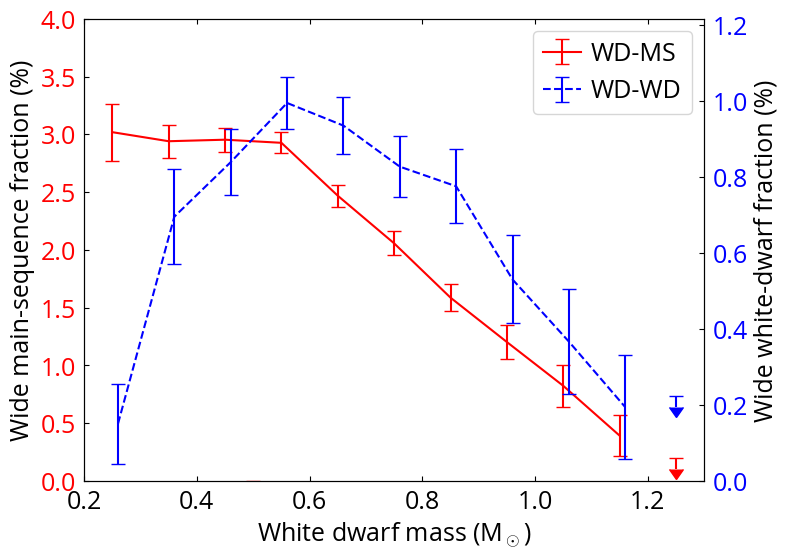

In [11]:

fig, ax1 = plt.subplots()

t = (
    WDMS_mass.n != 0
)
ax1.errorbar(
    WDMS_mass.xbins_center[t],
    WDMS_mass.frac[t]*100,
    yerr=WDMS_mass.fracerr[t]*100,
    capsize=5,
    label='WD-MS', c='r'
)
t = (
    WDMS_mass.n == 0
)
ax1.errorbar(
    WDMS_mass.xbins_center[t],
    WDMS_mass.uplim[t]*100,
    yerr=0.1,
    uplims=True,
    capsize=5,
    label='', c='r'
)
ax1.tick_params(axis='y', labelcolor='r')
ax1.set_ylim(0., 4.)

ax2 = ax1.twinx() 

ax2.errorbar(
    [0.5],[-1],yerr=[1], capsize=5,
    label='WD-MS', c='r'
)

t = (
    WDWD_mass.n != 0
)
ax2.errorbar(
    WDWD_mass.xbins_center[t] + 0.01,
    WDWD_mass.frac[t]*100,
    yerr=WDWD_mass.fracerr[t]*100,
    capsize=5, ls='--',
    label='WD-WD', c='b'
)


t = (
    WDWD_mass.n == 0
)
ax2.errorbar(
    WDWD_mass.xbins_center[t] + 0.0,
    WDWD_mass.uplim[t]*100,
    yerr=0.03,
    capsize=5,
    uplims=True,
    label='', c='b'
)


ax2.tick_params(axis='y', labelcolor='b')
ax1.set_xlabel(r'White dwarf mass (M$_\odot$)')
ax1.set_ylabel('Wide main-sequence fraction (%)')
ax2.set_ylabel('Wide white-dwarf fraction (%)')
plt.ylim(0., None)
plt.legend()
#plt.savefig('figs/20240819_WBF_mass.png', dpi=200)
plt.show()


Updated coefficients to map from bprp colors to mass on the main sequence (Hwang+2024)

In [12]:

z = [ 0.00423587, -0.03437772,  0.02810572,  0.42077499, -1.45388196,  1.95774974]
bprp_to_mass = np.poly1d(z)



In [13]:
#obtain the MS mass for the MS companions
wd_table['MS_companion_mass'] = bprp_to_mass(wd_table['companion_bp_rp'])

/Users/Hwang/opt/miniconda3/envs/python11/lib/python3.11/site-packages/numpy/ma/core.py:1020: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)


In [15]:
t_highmassWD = (
    (wd_table['Pwd'] > 0.9) *
    (wd_table['parallax'] > 4) *
    (wd_table['parallax_over_error'] > 5) * 
    (wd_table['parallax_error'] < 2) *
    ((wd_table['N_neighbors'] <= 30).data *  (~(wd_table['N_neighbors'] <= 30).mask))*
    (wd_table['phot_g_mean_flux_over_error'] > 10) *
    (wd_table['phot_bp_mean_flux_over_error'] > 10) *
    (wd_table['phot_rp_mean_flux_over_error'] > 10) *
    (wd_table['phot_bp_rp_excess_factor'] < 1.8) *
    (wd_table['ruwe'] < 1.4) *
    (abs(wd_table['b']) > 10.) *
    (wd_table['mass'] > 0.5) *
    (wd_table['companion_sep_AU'] > 1e3) *
    (wd_table['companion_sep_AU'] < 1e4) *
    (wd_table['companion_binary_type'] == 'WDMS') 
)

t_highmassWD = t_highmassWD.data * (~t_highmassWD.mask)

#bins = np.arange(-0.5, 5., 0.25)
bins = np.arange(-1, 5, 0.5)
t_lowmassWD = (
    (wd_table['Pwd'] > 0.9) *
    (wd_table['parallax'] > 4) *
    (wd_table['parallax_over_error'] > 5) * 
    (wd_table['parallax_error'] < 2) *
    ((wd_table['N_neighbors'] <= 30).data *  (~(wd_table['N_neighbors'] <= 30).mask))*
    (wd_table['phot_g_mean_flux_over_error'] > 10) *
    (wd_table['phot_bp_mean_flux_over_error'] > 10) *
    (wd_table['phot_rp_mean_flux_over_error'] > 10) *
    (wd_table['phot_bp_rp_excess_factor'] < 1.8) *
    (wd_table['ruwe'] < 1.4) *
    (abs(wd_table['b']) > 10.) *
    (wd_table['Pwd'] > 0.9) *
    (wd_table['mass'] < 0.5) *
    (wd_table['companion_sep_AU'] > 1e3) *
    (wd_table['companion_sep_AU'] < 1e4) *
    (wd_table['companion_binary_type'] == 'WDMS') 
)
t_lowmassWD = t_lowmassWD.data * (~t_lowmassWD.mask)

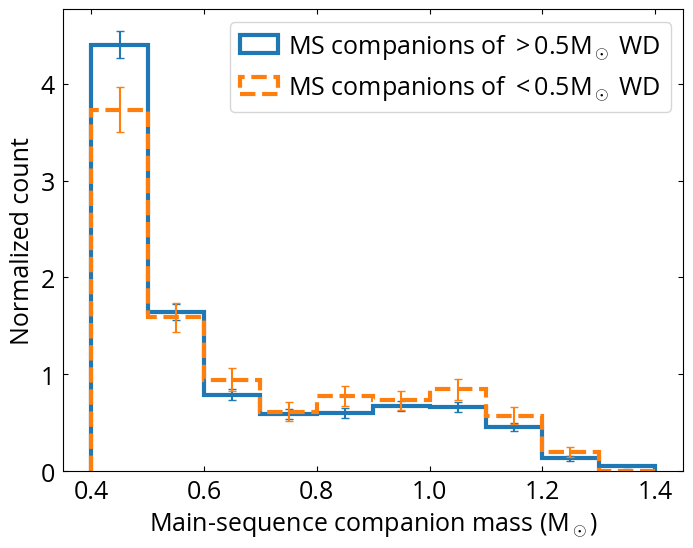

In [31]:
bins = np.arange(0.4, 1.5, 0.1)

plt.hist(
    wd_table['MS_companion_mass'][t_highmassWD],
    density=1, 
    histtype='step', bins=bins,
    label='MS companions of $>0.5$M$_\odot$ WD', lw=3
)

hist_res = np.histogram(
    wd_table['MS_companion_mass'][t_highmassWD],
    bins=bins,
)


plt.errorbar(
    0.5*(bins[0:-1]+bins[1:]),
    10*hist_res[0]/hist_res[0].sum(),
    yerr=10*np.sqrt(hist_res[0])/hist_res[0].sum(),
    c='C0', capsize=3, ls=''
)


plt.hist(
    wd_table['MS_companion_mass'][t_lowmassWD],
    density=1, 
    histtype='step', bins=bins,
    label='MS companions of $<0.5$M$_\odot$ WD', lw=3, ls='--'
)


hist_res = np.histogram(
    wd_table['MS_companion_mass'][t_lowmassWD],
    bins=bins,
)


plt.errorbar(
    0.5*(bins[0:-1]+bins[1:]),
    10*hist_res[0]/hist_res[0].sum(),
    yerr=10*np.sqrt(hist_res[0])/hist_res[0].sum(),
    c='C1', capsize=3, ls=''
)


plt.legend()
plt.xlabel(r'Main-sequence companion mass (M$_\odot$)')
plt.ylabel('Normalized count')

#plt.savefig('../figs/20250712_MSmass.png', dpi=200)
plt.show()

In [22]:
hist_res

(array([1004,  375,  180,  134,  136,  153,  151,  104,   30,   12]),
 array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4]))

In [33]:
field = Table.read('../KEB21_codes/field_wb_phot.fits')

In [36]:
field['absg_1'] = field['phot_g_mean_mag_1'] + 5 * np.log10(field['parallax']) - 10.
field['absg_2'] = field['phot_g_mean_mag_2'] + 5 * np.log10(field['parallax']) - 10.

field['mass_1'] = bprp_to_mass(field['bp_rp_1'])

c = SkyCoord(field['ra'].value, field['dec'].value, frame='icrs', unit='deg')
field['b'] = c.galactic.b.value


In [37]:
#wide-binary fraction for field MS-MS, with respect to MS mass

mass_bins = np.arange(0., 2.1, 0.25)


MSMS_mass = fraction_function(mass_bins, label='MS-MS')

denominator_criteria = (
    (field['parallax'] > 4) *
    #(field['parallax_over_error'] > 5) * 
    (field['parallax'] / field['parallax_error'] > 5) *
    (field['parallax_error'] < 2) *
    ((field['N_neighbors'] <= 30).data )*
    #(field['phot_g_mean_flux_over_error_1'] > 10) *
    (field['phot_bp_mean_flux_over_error_1'] > 10) *
    (field['phot_rp_mean_flux_over_error_1'] > 10) *
    (field['phot_bp_rp_excess_factor_1'] < 1.8) *
    (field['ruwe_1'] < 1.4) *
    (abs(field['b']) > 10.) *
    (field['absg_1'] < 3.25 * field['bp_rp_1'] + 9.625)
)

numerator_criteria = (
    denominator_criteria * 
    (field['comp_sep_AU'] > 1e3) *
    (field['comp_sep_AU'] < 1e4) *
    # (field['phot_bp_mean_flux_over_error_2'] > 10) *
    # (field['phot_rp_mean_flux_over_error_2'] > 10) *
    # (field['phot_bp_rp_excess_factor_2'] < 1.8) *
    # (field['ruwe_2'] < 1.4) *
    (field['bp_rp_2']>MScomp_bprp_cut) *
    (field['absg_2'] < MScomp_absg_cut)
)



compute_fraction(field, MSMS_mass, 'mass_1', 
                 denominator_criteria=denominator_criteria,
                 numerator_criteria=numerator_criteria
                )



In [38]:
#initial-to-final (WD)mass relation 

Minit_list = np.arange(0.3, 7.2, 0.01)

Mfinal_list = np.zeros_like(Minit_list)

t = (
    (Minit_list >= 0.3) *
    (Minit_list < 2.85)
)

Mfinal_list[t] = 0.08 * Minit_list[t] + 0.489 




t = (
    (Minit_list >= 2.85) *
    (Minit_list < 3.60)
)

Mfinal_list[t] = 0.187 * Minit_list[t] + 0.184


t = (
    (Minit_list >= 3.60) *
    (Minit_list < 7.20)
)

Mfinal_list[t] = 0.107 * Minit_list[t] + 0.471


from scipy import interpolate

f_final_to_init = interpolate.interp1d(Mfinal_list, Minit_list, fill_value="extrapolate")

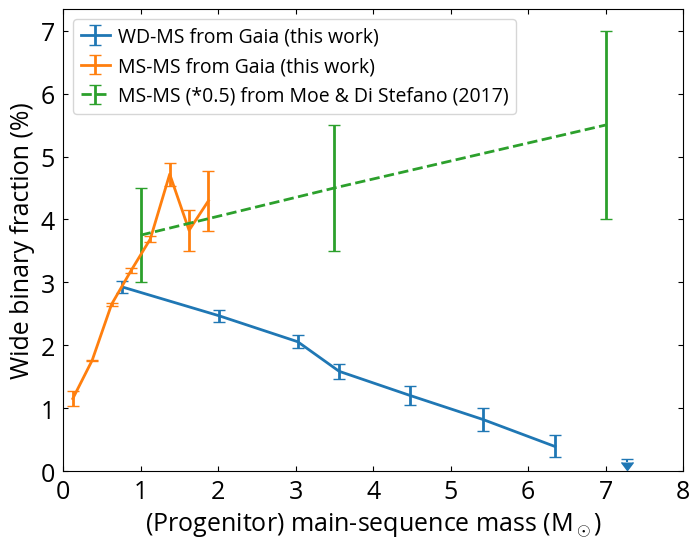

In [39]:


plt.errorbar(
    f_final_to_init(WDMS_mass.xbins_center[3:-1]),
    WDMS_mass.frac[3:-1]*100,
    yerr=WDMS_mass.fracerr[3:-1]*100,
    capsize=4, lw=2,
    label='WD-MS from Gaia (this work)', 
)

plt.errorbar(
    f_final_to_init(WDMS_mass.xbins_center[-1]),
    WDMS_mass.uplim[-1]*100,
    yerr=0.05,
    uplims=[True],
    capsize=4, c='C0',
    #label='WD-MS from Gaia (this work)', 
)

plt.errorbar(
    MSMS_mass.xbins_center,
    MSMS_mass.frac*100,
    yerr=MSMS_mass.fracerr*100,
    capsize=4, lw=2,
    label='MS-MS from Gaia (this work)',
)


norm_factor = 100 * 0.5
Moe_x = np.array([1., 3.5, 7.])
Moe_y = np.array([0.075, 0.09, 0.11])
Moe_yerr = np.array([0.015, 0.02, 0.03])
Moe_BF = interpolate.interp1d(
    Moe_x,
    norm_factor*Moe_y,
    fill_value="extrapolate")

plt.errorbar(
    Moe_x,
    norm_factor*Moe_y,
    yerr=norm_factor*Moe_yerr,
    capsize=4, linestyle='--', lw=2,
    label='MS-MS (*%.1f) from Moe & Di Stefano (2017)' %(norm_factor/100)
)

plt.legend(loc='upper left', fontsize=14)
plt.xlabel(r'(Progenitor) main-sequence mass (M$_\odot$)')
plt.ylabel('Wide binary fraction (%)')
plt.xlim(0, 8)
plt.ylim(0, None)
#plt.savefig('./figs/20240819_MS_WBF.png', dpi=200)
plt.show()

[1.1821018  1.00396951 0.89401511 0.79555727 0.60897407 0.47182533
 0.35110987 0.25149892 0.16307451 0.07369405 0.        ]
[1.1821018  1.00396951 0.89401511 0.99419443 0.54198906 0.47182533
 0.35110987 0.25149892 0.16307451 0.07369405 0.        ]


/var/folders/p2/5_2wys611fj9gl3f4r99njfw0000gn/T/ipykernel_18236/3904463727.py:5: RuntimeWarning: invalid value encountered in divide
  (WDMS_mass.fracerr/WDMS_mass.frac)**2 + (Moe_yerr[0]/Moe_y[0])**2


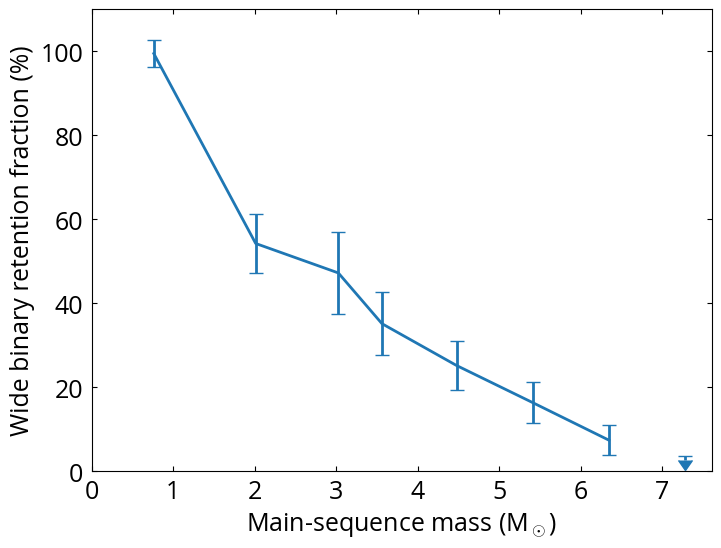

In [40]:

retention_frac = WDMS_mass.frac*100 / Moe_BF(f_final_to_init(WDMS_mass.xbins_center)) 

#retention_fracerr = brightWBF_mass.fracerr*100 / Moe_BF(f_final_to_init(brightWBF_mass.xbins_center)) 
retention_fracerr = retention_frac * np.sqrt(
    (WDMS_mass.fracerr/WDMS_mass.frac)**2 + (Moe_yerr[0]/Moe_y[0])**2
)

#use Gaia MS-MS

Gaia_frac_interp = interpolate.interp1d(
    MSMS_mass.xbins_center,
    MSMS_mass.frac*100,
    #yerr=MSMS_mass.fracerr*100,
    fill_value="extrapolate")


Gaia_fracerr_interp = interpolate.interp1d(
    MSMS_mass.xbins_center,
    #MSMS_mass.frac*100,
    MSMS_mass.fracerr*100,
    fill_value="extrapolate")

print(retention_frac)
for i in range(3, 5):
    retention_frac[i] = WDMS_mass.frac[i]*100 / Gaia_frac_interp(f_final_to_init(WDMS_mass.xbins_center[i]) )
    retention_fracerr[i] = retention_frac[i] * np.sqrt(
    (WDMS_mass.fracerr[i]/WDMS_mass.frac[i])**2 + (Gaia_fracerr_interp(f_final_to_init(WDMS_mass.xbins_center[i]) ) / Gaia_frac_interp(f_final_to_init(WDMS_mass.xbins_center[i]) ))**2
    )

print(retention_frac)
plt.errorbar(
    f_final_to_init(WDMS_mass.xbins_center)[3:-1],
    retention_frac[3:-1]*100.,
    yerr=retention_fracerr[3:-1]*100.,
    capsize=5, lw=2
)

plt.errorbar(
    f_final_to_init(WDMS_mass.xbins_center)[-1],
    100 * WDMS_mass.uplim[-1]*100 / Moe_BF(f_final_to_init(WDMS_mass.xbins_center[-1])) ,
    yerr=1,
    uplims=[True],
    capsize=5, lw=2, c='C0'
)

plt.xlabel('Main-sequence mass (M$_\odot$)')
plt.ylabel('Wide binary retention fraction (%)')

plt.ylim(0, 110)
plt.xlim(0., None)
#plt.savefig('figs/20240819_retention_frac.png', dpi=200)
plt.show()

## Eccentricity measurements ##

In [41]:
wb_table = Table.read('KE_all_columns_catalog.fits.gz')

In [42]:


#compute v-r agnle for eccentricity measurements. See detail in Hwang+22
wb_table['dpmra'] = wb_table['pmra2'] - wb_table['pmra1']
wb_table['dpmdec'] = wb_table['pmdec2'] - wb_table['pmdec1']
wb_table['dpmradec'] = np.sqrt(wb_table['dpmra']**2 + wb_table['dpmdec']**2)


wb_table['dra'] = (wb_table['ra2'] - wb_table['ra1']) * np.cos((wb_table['dec1']+wb_table['dec2'])/2. * np.pi / 180.)
wb_table['ddec'] = (wb_table['dec2'] - wb_table['dec1'])
wb_table['dradec'] = np.sqrt(wb_table['dra']**2 + wb_table['ddec']**2)

wb_table['vr_angle'] = 180. / np.pi * np.arccos((wb_table['dra'] * wb_table['dpmra'] + wb_table['ddec'] * wb_table['dpmdec']) / wb_table['dpmradec'] / wb_table['dradec'])


wb_table['dpm_error'] = 1. / wb_table['dpmradec'] * np.sqrt(
        wb_table['dpmra']**2 * (wb_table['pmra_error1']**2 + wb_table['pmra_error2']**2) +
        wb_table['dpmdec']**2 * (wb_table['pmdec_error1']**2 + wb_table['pmdec_error2']**2) 
    )

wb_table['dpm_over_error'] = wb_table['dpmradec'] / wb_table['dpm_error']


wb_table['vr_angle_error'] = 180. / np.pi / wb_table['dpm_over_error']

/var/folders/p2/5_2wys611fj9gl3f4r99njfw0000gn/T/ipykernel_18236/3940373061.py:11: RuntimeWarning: invalid value encountered in arccos
  wb_table['vr_angle'] = 180. / np.pi * np.arccos((wb_table['dra'] * wb_table['dpmra'] + wb_table['ddec'] * wb_table['dpmdec']) / wb_table['dpmradec'] / wb_table['dradec'])


In [43]:
s_wdms = (
    (wb_table['R_chance_align'] < 0.1) *
    (wb_table['binary_type'] == 'WDMS')
)
print(np.sum(s_wdms))

s_wdwd = (
    (wb_table['R_chance_align'] < 0.1) *
    (wb_table['binary_type'] == 'WDWD')
)
print(np.sum(s_wdwd))

16156
1390


In [44]:
import copy

In [45]:

s_common = (
    (wb_table['R_chance_align'] < 0.1) *
    (wb_table['dpm_over_error'] > 3) *
    (wb_table['parallax1'] > 5) *
    #(wb_table['sep_AU'] < 1000) *
    (wb_table['pairdistance'] * 3600. > 1.5)
)

s_WDMS_ecc = (
    s_common *
    (wb_table['binary_type'] == 'WDMS')
)
print(np.sum(s_WDMS_ecc))

s_WDWD_ecc = (
    s_common *
    (wb_table['binary_type'] == 'WDWD')
)
print(np.sum(s_WDWD_ecc))

3887
418


In [46]:
from scipy import interpolate

def hdpi_finder(x, y, level=0.68, N_accuracy=100):
    """
    y: density function in linear scale
    """
    
    yy = np.linspace(0, np.max(y), N_accuracy)
    
    z = np.zeros_like(yy)
    
    for i in range(len(yy)):
        z[i] = np.sum(y[y > yy[i]])
        
    
    z = z/z[0] #normalization
    
    f = interpolate.interp1d(z, yy)
    
    #idx = np.where(z>level)[0][-1]

    y_at_level = f(level)

    
    try:

        t = (
            x <= x[np.argmax(y)]
        )

        f0 = interpolate.interp1d(y[t], x[t])

        t = (
            x >= x[np.argmax(y)]
        )

        f1 = interpolate.interp1d(y[t], x[t])

        #can do an intepolation here if necessary

        return [f0(y_at_level), f1(y_at_level)]
    except ValueError:
        return[0., 0.]
    
    


In [47]:
def measure_alpha(file_path, to_print=False,
                  sep_list = np.array([100., 400., 1000.])
                 ):

    
    lp_list_list = []
    for i in range(len(sep_list) - 1):
        try:
            alpha_list, lp_list_tmp = np.load(file_path + 'sep_%d_%d.npy' %(sep_list[i], sep_list[i+1]))
            lp_list_list.append(lp_list_tmp)
        except ValueError:
            print('No file is found: ' + file_path + 'sep_%d_%d.npy' %(sep_list[i], sep_list[i+1]))
#     alpha_list, lp_list_1 = np.load(file_path + 'logsep_20_25.npy')
#     alpha_list, lp_list_2 = np.load(file_path + 'logsep_25_30.npy')
#     alpha_list, lp_list_3 = np.load(file_path + 'logsep_30_35.npy')
#     alpha_list, lp_list_4 = np.load(file_path + 'logsep_35_40.npy')
#     alpha_list, lp_list_5 = np.load(file_path + 'logsep_40_45.npy')
#     alpha_list, lp_list_6 = np.load(file_path + 'logsep_45_50.npy')




    #lp_list_list = [lp_list_0, lp_list_1, lp_list_2, lp_list_3, lp_list_4, lp_list_5, lp_list_6]


    #lp_list_list = [lp_list_0]

    #logsep1_list = np.array([1.5, 2., 2.5, 3., 3.5, 4.0, 4.5, 5.0])
    #logsepcenter_list = np.array([1.75, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75])
    logsepcenter_list = 0.5 * (sep_list[0:-1] + sep_list[1:])
    
    if to_print:
        plt.figure()
        
        for i, lp_list in enumerate(lp_list_list):
            plt.plot(
                alpha_list,
                lp_list - np.max(lp_list),
                label=r'$10^{%.1f}-10^{%.1f}$ AU' %(sep_list[i], sep_list[i+1])
            )

        plt.legend()

        plt.xlabel(r'$\alpha$')
        plt.ylabel('Ln(probability) + constant')
        plt.show()

    best_alpha_list = []
    alpha_0_list = []
    alpha_1_list = []
    for lp_list in lp_list_list:
        best_alpha = alpha_list[np.argmax(lp_list)]
        t = (
            (lp_list - np.max(lp_list) > -0.5)
        )
        alpha_0 = alpha_list[t][0]
        alpha_1 = alpha_list[t][-1]

        best_alpha_list.append(best_alpha)
        alpha_0_list.append(alpha_0)
        alpha_1_list.append(alpha_1)

    best_alpha_list = np.array(best_alpha_list)
    alpha_0_list = np.array(alpha_0_list)
    alpha_1_list = np.array(alpha_1_list)
    
    hdpi_list = []

    for i, lp_list in enumerate(lp_list_list):
        print(i)
        hdpi = hdpi_finder(alpha_list, np.exp(lp_list - np.max(lp_list)))
        hdpi_list.append(hdpi)

    hdpi_list = np.array(hdpi_list).T
    
    
    return best_alpha_list, hdpi_list

In [48]:
def measure_alpha_logsep(file_path, to_print=False,
                  logsep1_list = np.array([1.5, 2., 2.5, 3., 3.5, 4.0, 4.5, 5.0])
                 ):

    
    lp_list_list = []
    for i in range(len(logsep1_list) - 1):
        try:
            alpha_list, lp_list_tmp = np.load(file_path + 'logsep_%d_%d.npy' %(logsep1_list[i]*10, logsep1_list[i+1]*10))
            lp_list_list.append(lp_list_tmp)
        except ValueError:
            print('No file is found: ' + file_path + 'logsep_%d_%d.npy' %(logsep1_list[i]*10, logsep1_list[i+1]*10))
#     alpha_list, lp_list_1 = np.load(file_path + 'logsep_20_25.npy')
#     alpha_list, lp_list_2 = np.load(file_path + 'logsep_25_30.npy')
#     alpha_list, lp_list_3 = np.load(file_path + 'logsep_30_35.npy')
#     alpha_list, lp_list_4 = np.load(file_path + 'logsep_35_40.npy')
#     alpha_list, lp_list_5 = np.load(file_path + 'logsep_40_45.npy')
#     alpha_list, lp_list_6 = np.load(file_path + 'logsep_45_50.npy')




    #lp_list_list = [lp_list_0, lp_list_1, lp_list_2, lp_list_3, lp_list_4, lp_list_5, lp_list_6]


    #lp_list_list = [lp_list_0]

    #logsep1_list = np.array([1.5, 2., 2.5, 3., 3.5, 4.0, 4.5, 5.0])
    #logsepcenter_list = np.array([1.75, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75])
    logsepcenter_list = 0.5 * (logsep1_list[0:-1] + logsep1_list[1:])
    
    if to_print:
        plt.figure()
        
        for i, lp_list in enumerate(lp_list_list):
            plt.plot(
                alpha_list,
                lp_list - np.max(lp_list),
                label=r'$10^{%.1f}-10^{%.1f}$ AU' %(logsep1_list[i], logsep1_list[i+1])
            )

        plt.legend()

        plt.xlabel(r'$\alpha$')
        plt.ylabel('Ln(probability) + constant')
        plt.show()

    best_alpha_list = []
    alpha_0_list = []
    alpha_1_list = []
    for lp_list in lp_list_list:
        best_alpha = alpha_list[np.argmax(lp_list)]
        t = (
            (lp_list - np.max(lp_list) > -0.5)
        )
        alpha_0 = alpha_list[t][0]
        alpha_1 = alpha_list[t][-1]

        best_alpha_list.append(best_alpha)
        alpha_0_list.append(alpha_0)
        alpha_1_list.append(alpha_1)

    best_alpha_list = np.array(best_alpha_list)
    alpha_0_list = np.array(alpha_0_list)
    alpha_1_list = np.array(alpha_1_list)
    
    hdpi_list = []

    for i, lp_list in enumerate(lp_list_list):
        print(i)
        hdpi = hdpi_finder(alpha_list, np.exp(lp_list - np.max(lp_list)))
        hdpi_list.append(hdpi)

    hdpi_list = np.array(hdpi_list).T
    
    
    return best_alpha_list, hdpi_list

In [50]:
WDMS_mean_logsep_list = np.array([])
WDMS_median_logsep_list = np.array([])

WDWD_mean_logsep_list = np.array([])
WDWD_median_logsep_list = np.array([])

sep_list = [100, 1000, 3000]

for i in range(len(sep_list) - 1):
    s = (
        s_WDMS_ecc *
        (wb_table['sep_AU'] > sep_list[i]) *
        (wb_table['sep_AU'] < sep_list[i+1]) 
    )
    
    WDMS_mean_logsep_list = np.append(WDMS_mean_logsep_list, np.log10(np.mean(wb_table['sep_AU'][s])))
        
    WDMS_median_logsep_list = np.append(WDMS_median_logsep_list, np.log10(np.median(wb_table['sep_AU'][s])))


    s = (
        s_WDWD_ecc *
        (wb_table['sep_AU'] > sep_list[i]) *
        (wb_table['sep_AU'] < sep_list[i+1]) 
    )
    
    WDWD_mean_logsep_list = np.append(WDWD_mean_logsep_list, np.log10(np.mean(wb_table['sep_AU'][s])))
        
    WDWD_median_logsep_list = np.append(WDWD_median_logsep_list, np.log10(np.median(wb_table['sep_AU'][s])))



0
1
[0.82 1.04]
0
[0.22]
y = 1.25tanh((x - 1.87)/0.88) + 0.12
0
1
2
3
4
5
6
7
8


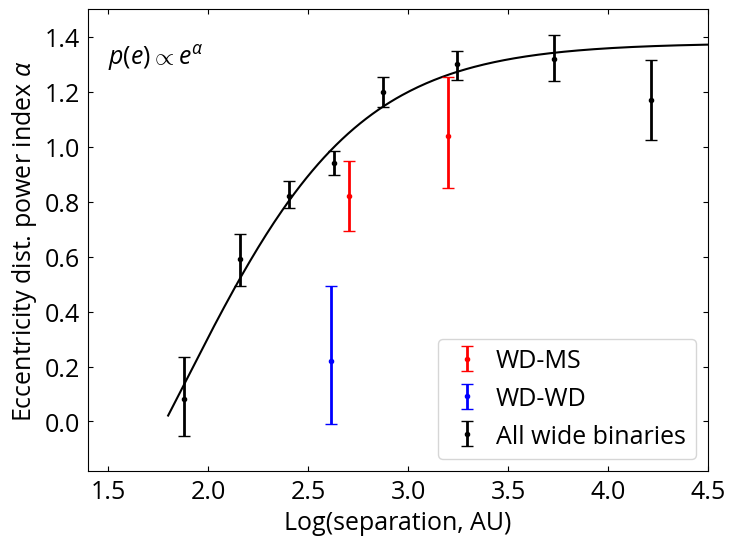

In [55]:

best_alpha_list2, hdpi_list2 = measure_alpha('./9_results_WDMS/', 
                        sep_list = np.array([100, 1000, 3000])
                    
                                           )

print(best_alpha_list2)

plt.errorbar(
    WDMS_median_logsep_list,
    best_alpha_list2,
    yerr=np.abs(hdpi_list2 - best_alpha_list2),
    capsize=4,
    c='r', ls='', lw=2, fmt='.', label='WD-MS'
)

best_alpha_list2, hdpi_list2 = measure_alpha('./9_results_WDWD/', 
                        sep_list = np.array([100, 1000])
                    
                                           )

print(best_alpha_list2)

plt.errorbar(
    #median_logsep_list[1],
    WDWD_median_logsep_list[0],
    best_alpha_list2,
    yerr=np.abs(hdpi_list2 - best_alpha_list2),
    capsize=4,
    c='b', lw=2, fmt='.', label='WD-WD'
)


x_list = np.arange(1.8, 5.0, 0.01)


def arctan_func(x, x0, x_scale, a, b):
    return a * np.arctan((x - x0)/x_scale) + b

def tanh_func(x, x0, x_scale, a):
    return a * np.tanh((x - x0)/x_scale) + 1. - a

def tanh_func2(x, x0, x_scale, a, b):
    return a * np.tanh((x - x0)/x_scale) + b

def tanh_func_ABC(x, A, B, C):
    return A * np.tanh((x - B)/C) + A

def tanh_func2_ABCD(x, A, B, C, D):
    return A * np.tanh((x - B)/C) + D
    


A, B, C, D = [1.25467084, 1.87076218, 0.87855077, 0.12243596]


function_output = r'y = %.2ftanh((x - %.2f)/%.2f) + %.2f' %(A, B, C, D)
print(function_output)


best_alpha_list_allwb, hdpi_list_allwb = measure_alpha_logsep('../../2021_6_wide_binary_eccentricity/16_address_referee_report/7_results/', 
                        logsep1_list = np.array([1.5, 2., 2.25, 2.5, 2.75, 3., 3.5, 4.0, 4.5, 5.0])
                    
                                            )

mean_logsep_list_allwb = np.array([1.87926548, 2.1617371 , 2.4061423 , 2.62830103, 2.87597759,
       3.24371023, 3.72731212, 4.21460896, 4.69300877])
plt.errorbar(
    mean_logsep_list_allwb,
    best_alpha_list_allwb,
    yerr=np.abs(hdpi_list_allwb - best_alpha_list_allwb),
    capsize=4,
    c='k', ls='', lw=2, fmt='.', label='All wide binaries'
)

plt.plot(
    x_list,
    A * np.tanh((x_list - B)/C) + D,
     c='k', label=None, zorder=1
)



plt.xlim(1.4, 4.5)
plt.ylim(None, 1.5)

plt.xlabel('Log(separation, AU)')
plt.ylabel(r'Eccentricity dist. power index $\alpha$')
plt.legend(loc='lower right')
plt.text(1.5, 1.3, r'$p(e)\propto e^\alpha$')
#plt.savefig('figs/20240819_WD_ecc_2.png', dpi=200)
plt.show()